In [1]:
import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Compressed_data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/Compressed_data/test/pneumonia/person14_virus_44.jpeg
/content/drive/MyDrive/Compressed_data/test/pneumonia/person15_virus_46.jpeg
/content/drive/MyDrive/Compressed_data/test/pneumonia/person10_virus_35.jpeg
/content/drive/MyDrive/Compressed_data/test/pneumonia/person11_virus_38.jpeg
/content/drive/MyDrive/Compressed_data/test/pneumonia/person19_virus_50.jpeg
/content/drive/MyDrive/Compressed_data/test/pneumonia/person8_virus_27.jpeg
/content/drive/MyDrive/Compressed_data/test/pneumonia/person3_virus_17.jpeg
/content/drive/MyDrive/Compressed_data/test/pneumonia/person78_bacteria_386.jpeg
/content/drive/MyDrive/Compressed_data/test/pneumonia/person1_virus_13.jpeg
/content/drive/MyDrive/Compressed_data/test/pneumonia/person21_virus_52.jpeg
/content/drive/MyDrive/Compressed_data/test/pneumonia/person80_bacteria_390.jpeg
/content/drive/MyDrive/Compressed_data/test/pneumonia/person1_virus_9.jpeg
/content/drive/MyDrive/Compressed_data/test/pneumonia/person80_bacteria_3

In [2]:
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np 
import cv2
import os
%matplotlib inline  

In [3]:
base_directory='/content/drive/MyDrive/Compressed_data/'
train_pneumonia=os.listdir('/content/drive/MyDrive/Compressed_data/train/pneumonia/')
train_normal=os.listdir('/content/drive/MyDrive/Compressed_data/train/normal/')
val_dir_normal=os.listdir('/content/drive/MyDrive/Compressed_data/val/normal/')
test_dir_normal=os.listdir('/content/drive/MyDrive/Compressed_data/test/normal/')
val_dir_pneumonia=os.listdir('/content/drive/MyDrive/Compressed_data/val/pneumonia/')
test_dir_pneumonia=os.listdir('/content/drive/MyDrive/Compressed_data/test/normal/')

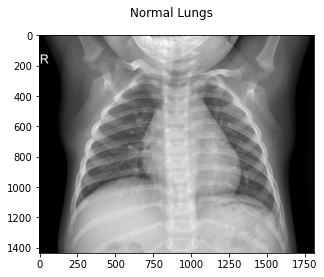

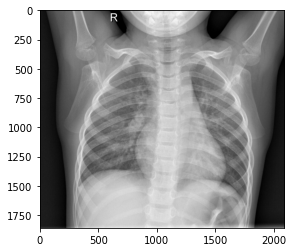

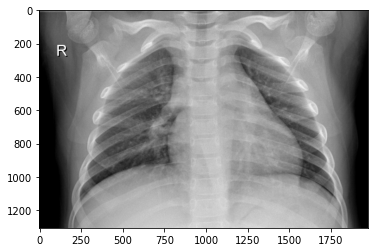

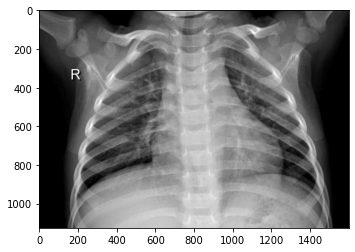

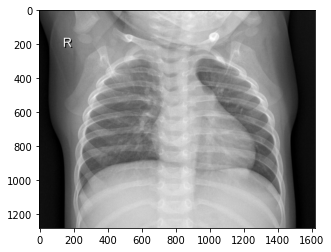

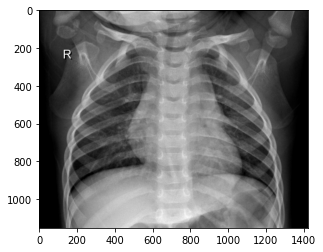

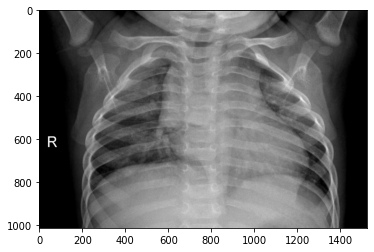

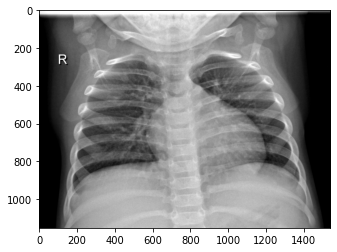

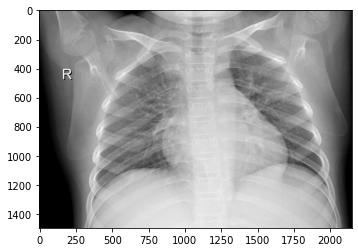

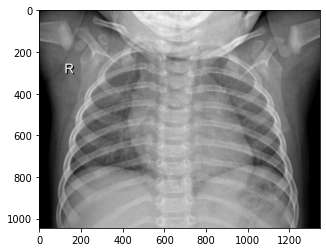

In [4]:
# Normal Lungs
from keras.preprocessing.image import ImageDataGenerator, load_img
plt.suptitle('Normal Lungs')
for i in range(0,10):
    img = train_normal[i]
    img = load_img('/content/drive/MyDrive/Compressed_data/train/normal/' + img)
    plt.imshow(img)
    plt.show()

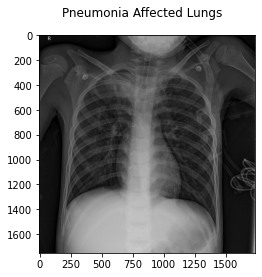

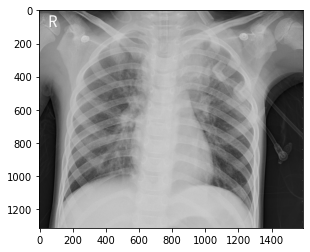

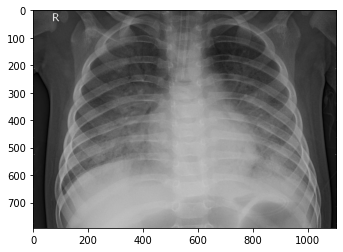

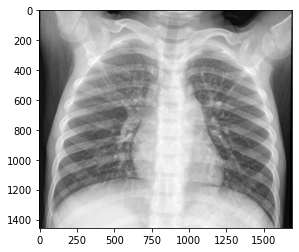

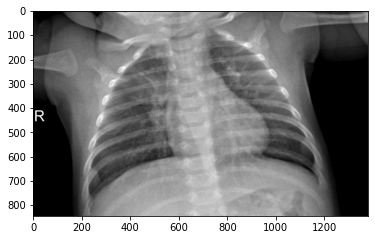

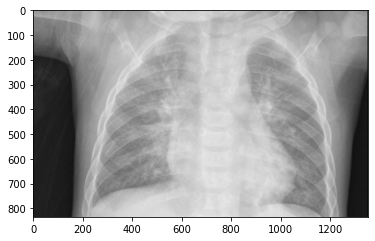

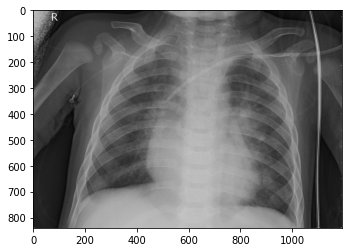

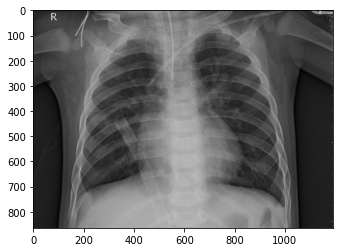

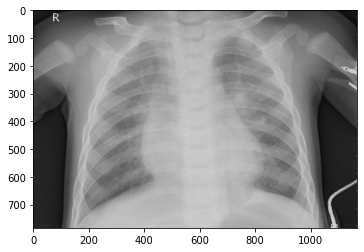

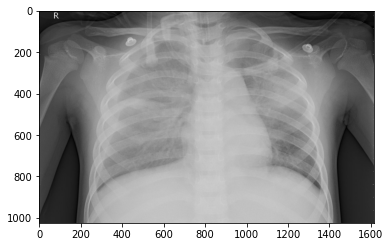

In [5]:
# Normal Lungs
plt.suptitle('Pneumonia Affected Lungs')
for i in range(0,10):
    img = train_pneumonia[i]
    img = load_img('/content/drive/MyDrive/Compressed_data/train/pneumonia/' + img)
    plt.imshow(img)
    plt.show()

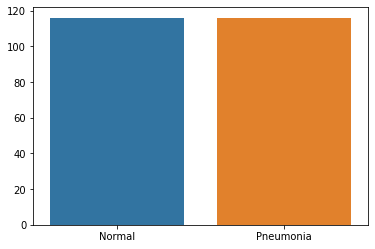

In [6]:
sns.barplot(x=['Normal','Pneumonia'],y=[len(train_normal),len(train_pneumonia)])

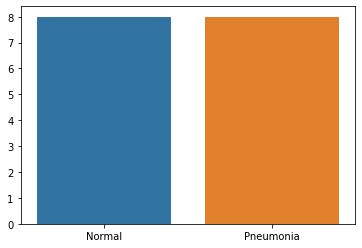

In [7]:
sns.barplot(x=['Normal','Pneumonia'],y=[len(val_dir_normal),len(val_dir_pneumonia)])

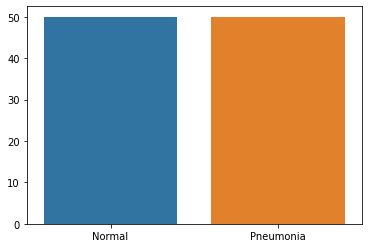

In [8]:
sns.barplot(x=['Normal','Pneumonia'],y=[len(test_dir_normal),len(test_dir_pneumonia)])

In [14]:
y_train_temp=[]
for i in range(len(train_normal)):
    y_train_temp.append(0)
for i in range(len(train_pneumonia)):
    y_train_temp.append(1)
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train_temp), y_train_temp)

In [15]:
print(class_weights)

[1. 1.]


In [9]:
train_datagen=ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=7,
    width_shift_range=0.5,
    height_shift_range=0.45,
    shear_range=0.2,
    zoom_range=0.45,
    horizontal_flip=True
    
)
test_datagen=ImageDataGenerator(
    rescale=1/255.0
)

In [10]:
 train_set=train_datagen.flow_from_directory('/content/drive/MyDrive/Compressed_data/train/',
                                                 target_size=(224, 224),
                                                 batch_size=32,
                                                 shuffle=True,
                                                 class_mode='binary')

Found 232 images belonging to 2 classes.


In [11]:
val_set=test_datagen.flow_from_directory('/content/drive/MyDrive/Compressed_data/val/',
                                         target_size=(224,224),
                                         batch_size=32,
                                         class_mode='binary'
                                        )

Found 16 images belonging to 2 classes.


In [12]:
test_set=test_datagen.flow_from_directory('/content/drive/MyDrive/Compressed_data/test/',
                                          target_size=(224,224),
                                          batch_size=1,
                                          class_mode='binary',
                                          shuffle=False
)

Found 100 images belonging to 2 classes.


In [16]:
import tensorflow as tf
x=tf.keras.applications.Xception(include_top=False,input_shape=(224,224,3),weights='imagenet')
#pretrain_model_path = '/content/drive/My Drive/v3.h5'
mobile=x
#x.load_weights(pretrain_model_path)
input_image=tf.keras.layers.Input((224,224,3))
x=x (input_image)
x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(units=1024,activation='relu')(x)
x=tf.keras.layers.Dense(units=512,activation='relu')(x)
x=tf.keras.layers.Dense(1)(x)
out=tf.keras.layers.Activation(activation='sigmoid')(x)

model=tf.keras.Model(inputs=input_image,outputs=out)

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),loss='binary_crossentropy',metrics=['accuracy','mae'])

83689472/83683744 [==============================] - 0s 0us/step


In [17]:
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              102761472 
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
_________________________________________________________________
activation (Activation)      (None, 1)                 0     

In [19]:
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def ifstopsthenresume(self):
      filepath = '/content/drive/MyDrive/Compressed_data/epochs/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5'
      checkpoint = ModelCheckpoint(filepath,monitor='val_acc',verbose=1,save_best_only=True,mode='max')
    
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["val_accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

In [20]:
my_callback = MyThresholdCallback(threshold=0.94)
history = model.fit_generator(train_set,
                    epochs=30,
                    validation_data=test_set,
                    callbacks=[my_callback]
                    )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
8/8 [==============================] - 314s 36s/step - loss: 0.8657 - accuracy: 0.6400 - mae: 0.4149 - val_loss: 0.8284 - val_accuracy: 0.5800 - val_mae: 0.4083
Epoch 2/30
8/8 [==============================] - 233s 29s/step - loss: 0.6347 - accuracy: 0.7084 - mae: 0.3341 - val_loss: 3.9667 - val_accuracy: 0.5000 - val_mae: 0.5014
Epoch 3/30
8/8 [==============================] - 233s 29s/step - loss: 0.5180 - accuracy: 0.7941 - mae: 0.3583 - val_loss: 1.3357 - val_accuracy: 0.5900 - val_mae: 0.4336
Epoch 4/30
8/8 [==============================] - 233s 29s/step - loss: 0.4927 - accuracy: 0.8011 - mae: 0.2939 - val_loss: 3.5255 - val_accuracy: 0.5000 - val_mae: 0.5034
Epoch 5/30
8/8 [==============================] - 232s 29s/step - loss: 0.4825 - accuracy: 0.8039 - mae: 0.3331 - val_loss: 1.3968 - val_accuracy: 0.5800 - val_mae: 0.4531
Epoch 6/30
8/8 [==============================] - 233s 29s/step - loss: 0.2648 - accuracy: 0.9115 - mae: 0.1729 - val_loss: 1.4602 - val_acc

In [21]:
predict=model.evaluate(test_set)

100/100 [==============================] - 28s 284ms/step - loss: 1.3995 - accuracy: 0.7900 - mae: 0.2145


In [22]:
print(predict)

[1.3995479345321655, 0.7900000214576721, 0.21450532972812653]


In [52]:
predicted=model.predict_generator(test_set,steps=100)
result=np.array(predicted>0.5,dtype='int32')
result

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


array([[0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
    

In [ ]:
x_test=test_set.classes
tester1=x_test.reshape((100,1))
tester1

In [29]:
from sklearn.metrics import confusion_matrix
metrics=confusion_matrix(test_set.classes,result)
print(metrics)

[[32 18]
 [ 3 47]]


In [34]:
test_set[1][1]

array([0.], dtype=float32)

In [36]:
from sklearn.metrics import auc,roc_curve,roc_auc_score
fpr, tpr, thresholds = roc_curve(x_test,predicted)
auc = roc_auc_score(x_test, predicted)
print(auc)

0.9248000000000001


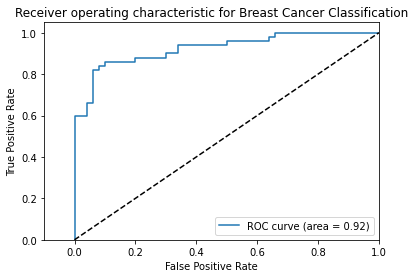

In [37]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr,label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Breast Cancer Classification')
plt.legend(loc="lower right")
plt.show()

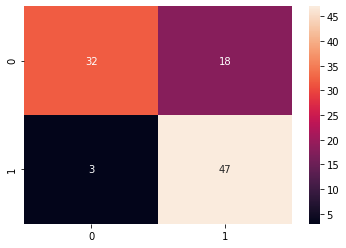

In [38]:
import seaborn as sns
sns.heatmap(metrics, annot=True, fmt="d",)

<Figure size 432x288 with 0 Axes>

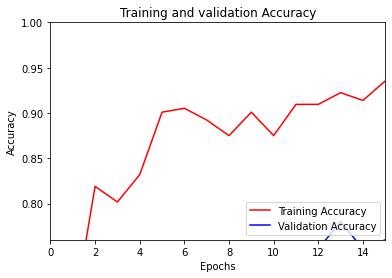

<Figure size 432x288 with 0 Axes>

In [39]:
import matplotlib.pyplot as plt
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['mae']
val_loss=history.history['val_mae']

epochs=range(len(acc))

plt.plot(epochs,acc,'r',label="Training Accuracy")
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
plt.ylim((0.760,1.00))
plt.xlim([0,15])
plt.title("Training and validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.figure()

<Figure size 432x288 with 0 Axes>

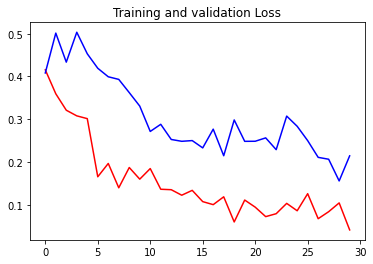

<Figure size 432x288 with 0 Axes>

In [53]:
plt.plot(epochs,loss,'r')
plt.plot(epochs,val_loss,'b')
plt.title("Training and validation Loss")
plt.figure()

In [54]:
from sklearn.metrics import precision_recall_fscore_support
precision=precision_recall_fscore_support(x_test,result,average='binary')
print(precision)

(0.7230769230769231, 0.94, 0.8173913043478259, None)
